# Imports

In [ ]:
from typing import List, Tuple
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelScale
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score

# Data Paths

In [63]:
data_path = '/kaggle/input/marked-data-256/data/marked_data_256'
labels_path = '/kaggle/input/marked-data-256/data/labels.csv'

# Define Dataloader

In [64]:
class WatermarksDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Map string labels to numeric for calssification
        self.label2idx = {label: idx for idx, label in enumerate(self.df['label'].unique())}
        self.df['label_idx'] = self.df['label'].map(self.label2idx)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['filename'] + ".png")
        # Read the image as Grayscale
        image = Image.open(img_path).convert("L")
        label = self.df.iloc[idx]['label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label

# Declare Dataloader

In [65]:
class FFTFlatten:
    def __call__(self, x):
        if not isinstance(x, torch.Tensor):
            x = transforms.ToTensor()(x)

        x_fft = torch.fft.fft2(x)
        x_fft = torch.abs(x_fft) + 1e-8
        x_fft = torch.log(x_fft)
        x_fft_flat = x_fft.view(-1)

        return x_fft_flat.float()

# Final transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),          # Converts PIL to (C, H, W) tensor
    # FFTFlatten(),                   # Apply FFT and flatten to 1D
])

dataset = WatermarksDataset(
    csv_file=labels_path,
    img_dir=data_path,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Example: iterate
for images, labels in dataloader:
    print(images.shape)

    break

torch.Size([16, 1, 256, 256])


# Split data

In [66]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures full coverage

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Define Network

In [ ]:
# class FourierInputMapping(nn.Module):
#     def __init__(self, input_dim, mapping_size=256, scale=10):
#         super().__init__()
#         self.B = nn.Parameter(torch.randn((input_dim, mapping_size)) * scale, requires_grad=False)
        
#     def forward(self, x):
#         # x: [batch_size, input_dim]
#         B = self.B.to(x.device)
#         x_proj = 2 * torch.pi * x @ B  # [batch_size, mapping_size]
#         return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# class FourierFeaturesNetwork(nn.Module):
#     def __init__(self, input_dim, num_classes, activation_fn, mapping_size=256, scale=10, hidden_dim=128):
#         super().__init__()
#         self.ffm = FourierInputMapping(input_dim, mapping_size=mapping_size, scale=scale)

#         self.net = nn.Sequential(
#             nn.Linear(2 * mapping_size, hidden_dim),
#             activation_fn,
#             nn.Linear(hidden_dim, hidden_dim),
#             activation_fn,
#             nn.Linear(hidden_dim, num_classes)
#         )

#     def forward(self, x):
#         x = self.ffm(x)
#         return self.net(x)

In [ ]:
import torch
import torch.nn as nn

class DualBranchFFTNetwork(nn.Module):
    def __init__(self, input_dim, num_classes, activation_fn, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        flat_dim = input_dim * input_dim  # 2D image flattened

        # Magnitude processing branch
        self.mag_branch = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, hidden_dim // 2),
            activation_fn
        )

        # Phase/time processing branch (using raw input for now)
        self.time_branch = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, hidden_dim // 2),
            activation_fn
        )

        # Combined classifier (input = mag + time branch output)
        combined_feature_dim = (hidden_dim // 2) * 2
        self.classifier = nn.Sequential(
            nn.Linear(combined_feature_dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = x.squeeze(1)  # [B, H, W]

        # Normalize
        x = (x - torch.mean(x, dim=(1,2), keepdim=True)) / (torch.std(x, dim=(1,2), keepdim=True) + 1e-8)

        # FFT
        x_fft = torch.fft.fft2(x)

        # Magnitude path
        mag = torch.abs(x_fft) + 1e-8
        mag_log = torch.log(mag)
        mag_flat = mag_log.view(x.size(0), -1)
        mag_features = self.mag_branch(mag_flat)

        # Time-domain path
        time_flat = x.view(x.size(0), -1)
        time_features = self.time_branch(time_flat)

        # Concatenate and classify
        combined = torch.cat((mag_features, time_features), dim=1)
        return self.classifier(combined)


In [69]:
# Implementation from https://medium.com/data-scientists-diary/implementing-focal-loss-in-pytorch-for-class-imbalance-24d8aa3b59d9
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # controls class imbalance
        self.gamma = gamma  # focuses on hard examples
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate Binary Cross-Entropy Loss for each sample
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute pt (model confidence on true class)
        pt = torch.exp(-BCE_loss)

        # Apply the focal adjustment
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Apply reduction (mean, sum, or no reduction)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [70]:
import torch
import os

torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Hyperparameters

In [71]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
hyperparams = {
    'optimizer': 'adam',
    'lr': 0.001,
    'momentum': 0.0,
    'num_epochs': 80,
    'hidden_size': 64,
    'num_classes': 4,
    'scale': 10,
    'mapping_size': 256,
    'activation_fn': nn.ReLU(),
    'loss_fn': 'focal_loss',
    'class_weights': torch.tensor([1.0, 1.05, 1.0, 1.0]).to(device),
    'alpha': torch.tensor([1, 2, 1, 2]).to(device),
    'gamma': 2
}

In [72]:
# model_fnn = FourierFeaturesNetwork(input_dim=2, 
#                                num_classes=4, 
#                                scale=hyperparams['scale'],
#                                mapping_size=hyperparams['mapping_size'],
#                                activation_fn=hyperparams['activation_fn'],
#                                hidden_dim=hyperparams['hidden_size'])
torch.cuda.empty_cache()

model = DualBranchFFTNetwork(input_dim=256,
                   num_classes=hyperparams['num_classes'],
                   activation_fn=hyperparams['activation_fn'],
                   hidden_dim=hyperparams['hidden_size']).to(device)

if hyperparams['loss_fn'] == 'cross_entropy':
    loss_criterion = nn.CrossEntropyLoss(weight=hyperparams['class_weights'])
if hyperparams['loss_fn'] == 'focal_loss':
    loss_criterion = FocalLoss(alpha=hyperparams['alpha'], gamma=hyperparams['gamma']) 
    
optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=hyperparams['lr'],
        momentum=hyperparams['momentum']
    )

# Define train/eval

In [73]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []

    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_data, batch_labels = batch
        current_batch_size = batch_data.size(0)

        # Move data and labels to device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        output = model(batch_data)  # Input is already [batch, 1, 256, 256]

        # Prediction for metrics
        batch_predictions = torch.argmax(output, dim=1)
        predictions += batch_predictions.cpu().tolist()
        labels += batch_labels.cpu().tolist()

        # Create one-hot labels ON DEVICE
        batch_labels_onehot = torch.nn.functional.one_hot(
            batch_labels.long(), 
            num_classes=hyperparams['num_classes']
        ).float().to(device)

        # Compute loss
        loss = loss_crt(output, batch_labels_onehot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= num_batches
    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt, device):
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []

    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            batch_data, batch_labels = batch
            current_batch_size = batch_data.size(0)

            # Move data and labels to device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            output = model(batch_data)  # Input shape: [batch, 1, 256, 256]

            # Prediction for metrics
            batch_predictions = torch.argmax(output, dim=1)
            predictions += batch_predictions.cpu().tolist()
            labels += batch_labels.cpu().tolist()

            # Create one-hot labels ON DEVICE
            batch_labels_onehot = torch.nn.functional.one_hot(
                batch_labels.long(),
                num_classes=hyperparams['num_classes']
            ).float().to(device)

            # Compute loss
            loss = loss_crt(output, batch_labels_onehot)

            epoch_loss += loss.item()

    epoch_loss /= num_batches
    return epoch_loss, predictions, labels


# Train

In [74]:
def compute_accuracy(predictions: List[int], labels:List[int]) -> float:
    """
    Compute accuracy given the predictions of a binary classifier and the
    ground truth label.
    predictions: list of model predictions (0 or 1)
    labels: list of ground truth labels (0 or 1)
    """
    num_correct = len([(p,l) for (p,l) in zip(predictions,labels) if p==l])
    epoch_accuracy = num_correct/len(labels)

    return epoch_accuracy


In [75]:
import torch

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_model_path = "best_model.pth"  # You can change this path

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

validation_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

for epoch_idx in range(hyperparams['num_epochs']):

    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model,
        train_dataloader,
        loss_criterion,
        optimizer,
        device
    )

    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        validation_dataloader,
        loss_criterion,
        device
    )

    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx,
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

    # Save the model if it's the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with val acc = {best_val_acc:.4f}")

# Load the best model after training
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded with val acc = {:.4f}".format(best_val_acc))


280it [00:29,  9.61it/s]
60it [00:06,  9.42it/s]


epoch 0, train loss=0.203091, train acc=0.536607, val loss=0.186920, val acc=0.685000
New best model saved with val acc = 0.6850


280it [00:23, 11.80it/s]
60it [00:05, 10.64it/s]

epoch 1, train loss=0.173367, train acc=0.679357, val loss=0.158330, val acc=0.673667



280it [00:24, 11.59it/s]
60it [00:05, 10.96it/s]


epoch 2, train loss=0.148672, train acc=0.703000, val loss=0.140127, val acc=0.716333
New best model saved with val acc = 0.7163


280it [00:24, 11.40it/s]
60it [00:05, 11.51it/s]


epoch 3, train loss=0.134674, train acc=0.720036, val loss=0.130708, val acc=0.725000
New best model saved with val acc = 0.7250


280it [00:24, 11.23it/s]
60it [00:05, 10.85it/s]

epoch 4, train loss=0.126428, train acc=0.730321, val loss=0.123560, val acc=0.733333
New best model saved with val acc = 0.7333



280it [00:25, 11.16it/s]
60it [00:05, 11.29it/s]


epoch 5, train loss=0.120522, train acc=0.740500, val loss=0.118368, val acc=0.733500
New best model saved with val acc = 0.7335


280it [00:24, 11.47it/s]
60it [00:05, 11.43it/s]

epoch 6, train loss=0.116098, train acc=0.741643, val loss=0.114623, val acc=0.733833
New best model saved with val acc = 0.7338



280it [00:24, 11.57it/s]
60it [00:05, 11.51it/s]

epoch 7, train loss=0.112647, train acc=0.744821, val loss=0.111672, val acc=0.744500
New best model saved with val acc = 0.7445



280it [00:23, 11.76it/s]
60it [00:05, 11.52it/s]

epoch 8, train loss=0.109717, train acc=0.752143, val loss=0.109100, val acc=0.742833



280it [00:24, 11.64it/s]
60it [00:05, 11.60it/s]

epoch 9, train loss=0.107284, train acc=0.752929, val loss=0.106965, val acc=0.742167



280it [00:24, 11.64it/s]
60it [00:05, 11.45it/s]

epoch 10, train loss=0.105467, train acc=0.753714, val loss=0.106015, val acc=0.743833



280it [00:24, 11.49it/s]
60it [00:05, 11.67it/s]

epoch 11, train loss=0.103801, train acc=0.751214, val loss=0.103892, val acc=0.746000
New best model saved with val acc = 0.7460



280it [00:23, 11.77it/s]
60it [00:05, 11.04it/s]

epoch 12, train loss=0.102357, train acc=0.759571, val loss=0.102607, val acc=0.744333



280it [00:24, 11.65it/s]
60it [00:05, 10.68it/s]

epoch 13, train loss=0.101177, train acc=0.756179, val loss=0.101690, val acc=0.743167



280it [00:23, 11.69it/s]
60it [00:05, 10.84it/s]

epoch 14, train loss=0.100075, train acc=0.756643, val loss=0.101357, val acc=0.747000
New best model saved with val acc = 0.7470



280it [00:23, 11.77it/s]
60it [00:05, 11.56it/s]

epoch 15, train loss=0.099180, train acc=0.760107, val loss=0.100237, val acc=0.743833



280it [00:23, 11.71it/s]
60it [00:05, 11.62it/s]

epoch 16, train loss=0.098222, train acc=0.764357, val loss=0.099111, val acc=0.746000



280it [00:23, 11.69it/s]
60it [00:05, 11.47it/s]

epoch 17, train loss=0.097580, train acc=0.760714, val loss=0.099020, val acc=0.745167



280it [00:23, 11.72it/s]
60it [00:05, 11.52it/s]

epoch 18, train loss=0.096963, train acc=0.764821, val loss=0.097831, val acc=0.738667



280it [00:24, 11.59it/s]
60it [00:05, 11.59it/s]

epoch 19, train loss=0.096370, train acc=0.764964, val loss=0.097375, val acc=0.740667



280it [00:24, 11.61it/s]
60it [00:05, 11.12it/s]

epoch 20, train loss=0.095898, train acc=0.763929, val loss=0.097041, val acc=0.740833



280it [00:24, 11.36it/s]
60it [00:05, 11.20it/s]

epoch 21, train loss=0.095440, train acc=0.765214, val loss=0.096544, val acc=0.739000



280it [00:24, 11.39it/s]
60it [00:05, 10.88it/s]

epoch 22, train loss=0.095042, train acc=0.766964, val loss=0.097108, val acc=0.747833
New best model saved with val acc = 0.7478



280it [00:25, 11.18it/s]
60it [00:05, 11.09it/s]

epoch 23, train loss=0.094652, train acc=0.766357, val loss=0.096250, val acc=0.748667
New best model saved with val acc = 0.7487



280it [00:24, 11.42it/s]
60it [00:05, 11.03it/s]

epoch 24, train loss=0.094223, train acc=0.769036, val loss=0.095733, val acc=0.746833



280it [00:25, 10.96it/s]
60it [00:05, 10.90it/s]

epoch 25, train loss=0.094035, train acc=0.768393, val loss=0.095642, val acc=0.747500



280it [00:24, 11.21it/s]
60it [00:05, 10.68it/s]

epoch 26, train loss=0.093603, train acc=0.769714, val loss=0.095108, val acc=0.739667



280it [00:25, 11.14it/s]
60it [00:05, 10.16it/s]

epoch 27, train loss=0.093379, train acc=0.768786, val loss=0.095020, val acc=0.747167



280it [00:25, 10.87it/s]
60it [00:05, 10.20it/s]


epoch 28, train loss=0.093138, train acc=0.769464, val loss=0.094778, val acc=0.749000
New best model saved with val acc = 0.7490


280it [00:25, 11.00it/s]
60it [00:05, 10.12it/s]

epoch 29, train loss=0.092821, train acc=0.774214, val loss=0.094576, val acc=0.740000



280it [00:24, 11.60it/s]
60it [00:05, 10.58it/s]

epoch 30, train loss=0.092706, train acc=0.772429, val loss=0.094384, val acc=0.744500



280it [00:24, 11.41it/s]
60it [00:05, 11.07it/s]

epoch 31, train loss=0.092468, train acc=0.773464, val loss=0.094263, val acc=0.745000



280it [00:24, 11.26it/s]
60it [00:05, 11.13it/s]

epoch 32, train loss=0.092221, train acc=0.772071, val loss=0.094093, val acc=0.741000



280it [00:24, 11.38it/s]
60it [00:05, 11.50it/s]

epoch 33, train loss=0.091983, train acc=0.776250, val loss=0.094377, val acc=0.751667
New best model saved with val acc = 0.7517



280it [00:24, 11.26it/s]
60it [00:05, 10.83it/s]

epoch 34, train loss=0.091873, train acc=0.773857, val loss=0.094052, val acc=0.749500



280it [00:24, 11.25it/s]
60it [00:05, 11.46it/s]

epoch 35, train loss=0.091683, train acc=0.777107, val loss=0.093745, val acc=0.743500



280it [00:24, 11.33it/s]
60it [00:05, 11.16it/s]

epoch 36, train loss=0.091510, train acc=0.777036, val loss=0.094898, val acc=0.749167



280it [00:24, 11.28it/s]
60it [00:05, 11.50it/s]

epoch 37, train loss=0.091352, train acc=0.776714, val loss=0.094078, val acc=0.752000
New best model saved with val acc = 0.7520



280it [00:24, 11.35it/s]
60it [00:05, 10.92it/s]

epoch 38, train loss=0.091308, train acc=0.776714, val loss=0.093459, val acc=0.742833



280it [00:24, 11.30it/s]
60it [00:05, 11.15it/s]

epoch 39, train loss=0.091152, train acc=0.778893, val loss=0.093408, val acc=0.742167



280it [00:24, 11.34it/s]
60it [00:05, 10.93it/s]

epoch 40, train loss=0.090967, train acc=0.779393, val loss=0.094228, val acc=0.746167



280it [00:24, 11.45it/s]
60it [00:05, 11.32it/s]

epoch 41, train loss=0.090878, train acc=0.776964, val loss=0.093559, val acc=0.748333



280it [00:24, 11.56it/s]
60it [00:05, 11.48it/s]

epoch 42, train loss=0.090709, train acc=0.781071, val loss=0.093156, val acc=0.740833



280it [00:24, 11.50it/s]
60it [00:05, 11.41it/s]

epoch 43, train loss=0.090694, train acc=0.779214, val loss=0.093055, val acc=0.739333



280it [00:23, 11.70it/s]
60it [00:05, 10.43it/s]

epoch 44, train loss=0.090528, train acc=0.780821, val loss=0.093034, val acc=0.741000



280it [00:23, 11.67it/s]
60it [00:05, 10.57it/s]

epoch 45, train loss=0.090421, train acc=0.781143, val loss=0.092926, val acc=0.736500



280it [00:24, 11.56it/s]
60it [00:05, 11.42it/s]

epoch 46, train loss=0.090323, train acc=0.780750, val loss=0.093028, val acc=0.742333



280it [00:24, 11.51it/s]
60it [00:05, 11.52it/s]

epoch 47, train loss=0.090182, train acc=0.781214, val loss=0.093142, val acc=0.752833
New best model saved with val acc = 0.7528



280it [00:24, 11.45it/s]
60it [00:05, 11.35it/s]

epoch 48, train loss=0.090032, train acc=0.785750, val loss=0.092876, val acc=0.741667



280it [00:24, 11.47it/s]
60it [00:05, 11.53it/s]

epoch 49, train loss=0.090046, train acc=0.782607, val loss=0.093046, val acc=0.746833



280it [00:24, 11.37it/s]
60it [00:05, 10.95it/s]

epoch 50, train loss=0.089808, train acc=0.787857, val loss=0.093318, val acc=0.753167
New best model saved with val acc = 0.7532



280it [00:24, 11.35it/s]
60it [00:05, 11.44it/s]

epoch 51, train loss=0.089742, train acc=0.785179, val loss=0.093603, val acc=0.754000
New best model saved with val acc = 0.7540



280it [00:24, 11.62it/s]
60it [00:05, 11.39it/s]

epoch 52, train loss=0.089720, train acc=0.785500, val loss=0.092868, val acc=0.746167



280it [00:24, 11.44it/s]
60it [00:05, 11.44it/s]

epoch 53, train loss=0.089612, train acc=0.785036, val loss=0.092750, val acc=0.741833



280it [00:24, 11.60it/s]
60it [00:05, 11.34it/s]

epoch 54, train loss=0.089533, train acc=0.785607, val loss=0.093272, val acc=0.754000



280it [00:24, 11.53it/s]
60it [00:05, 11.65it/s]

epoch 55, train loss=0.089386, train acc=0.787607, val loss=0.092894, val acc=0.751833



280it [00:23, 11.81it/s]
60it [00:05, 11.00it/s]

epoch 56, train loss=0.089276, train acc=0.786964, val loss=0.092553, val acc=0.734000



280it [00:24, 11.47it/s]
60it [00:05, 10.63it/s]

epoch 57, train loss=0.089151, train acc=0.791107, val loss=0.092585, val acc=0.741667



280it [00:24, 11.67it/s]
60it [00:05, 10.79it/s]

epoch 58, train loss=0.089102, train acc=0.789036, val loss=0.092483, val acc=0.733167



280it [00:23, 11.76it/s]
60it [00:05, 11.65it/s]

epoch 59, train loss=0.089175, train acc=0.788500, val loss=0.092463, val acc=0.737000



280it [00:24, 11.55it/s]
60it [00:05, 11.36it/s]

epoch 60, train loss=0.089013, train acc=0.790464, val loss=0.092654, val acc=0.745333



280it [00:24, 11.46it/s]
60it [00:05, 11.63it/s]

epoch 61, train loss=0.088942, train acc=0.790786, val loss=0.093945, val acc=0.747000



280it [00:24, 11.50it/s]
60it [00:05, 11.16it/s]

epoch 62, train loss=0.088781, train acc=0.788500, val loss=0.092697, val acc=0.750333



280it [00:24, 11.29it/s]
60it [00:05, 10.87it/s]

epoch 63, train loss=0.088695, train acc=0.793250, val loss=0.093338, val acc=0.754000



280it [00:24, 11.21it/s]
60it [00:05, 11.32it/s]

epoch 64, train loss=0.088840, train acc=0.786857, val loss=0.092512, val acc=0.729000



280it [00:24, 11.30it/s]
60it [00:05, 11.27it/s]

epoch 65, train loss=0.088583, train acc=0.791179, val loss=0.093788, val acc=0.748000



280it [00:24, 11.53it/s]
60it [00:05, 11.21it/s]

epoch 66, train loss=0.088412, train acc=0.791786, val loss=0.092418, val acc=0.733667



280it [00:24, 11.46it/s]
60it [00:05, 11.13it/s]

epoch 67, train loss=0.088625, train acc=0.788250, val loss=0.093917, val acc=0.753833



280it [00:24, 11.42it/s]
60it [00:05, 11.35it/s]

epoch 68, train loss=0.088315, train acc=0.792393, val loss=0.092391, val acc=0.730667



280it [00:24, 11.55it/s]
60it [00:05, 11.63it/s]

epoch 69, train loss=0.088169, train acc=0.795357, val loss=0.092376, val acc=0.740167



280it [00:23, 11.73it/s]
60it [00:05, 10.49it/s]

epoch 70, train loss=0.088007, train acc=0.795571, val loss=0.095169, val acc=0.748333



280it [00:23, 11.69it/s]
60it [00:05, 10.56it/s]

epoch 71, train loss=0.088336, train acc=0.790929, val loss=0.094333, val acc=0.749167



280it [00:24, 11.66it/s]
60it [00:05, 11.33it/s]

epoch 72, train loss=0.087969, train acc=0.796679, val loss=0.092329, val acc=0.726833



280it [00:24, 11.43it/s]
60it [00:05, 11.34it/s]

epoch 73, train loss=0.087841, train acc=0.797071, val loss=0.092864, val acc=0.749000



280it [00:24, 11.54it/s]
60it [00:05, 11.29it/s]

epoch 74, train loss=0.087948, train acc=0.794393, val loss=0.092435, val acc=0.740833



280it [00:24, 11.50it/s]
60it [00:05, 11.42it/s]

epoch 75, train loss=0.087830, train acc=0.795750, val loss=0.092389, val acc=0.728500



280it [00:24, 11.55it/s]
60it [00:05, 11.32it/s]

epoch 76, train loss=0.087633, train acc=0.799679, val loss=0.092837, val acc=0.742833



280it [00:24, 11.50it/s]
60it [00:05, 11.50it/s]

epoch 77, train loss=0.087690, train acc=0.795893, val loss=0.096226, val acc=0.752167



280it [00:24, 11.55it/s]
60it [00:05, 11.41it/s]

epoch 78, train loss=0.087599, train acc=0.800357, val loss=0.092940, val acc=0.744667



280it [00:24, 11.58it/s]
60it [00:05, 11.74it/s]

epoch 79, train loss=0.087388, train acc=0.797714, val loss=0.092392, val acc=0.737167
Best model loaded with val acc = 0.7540


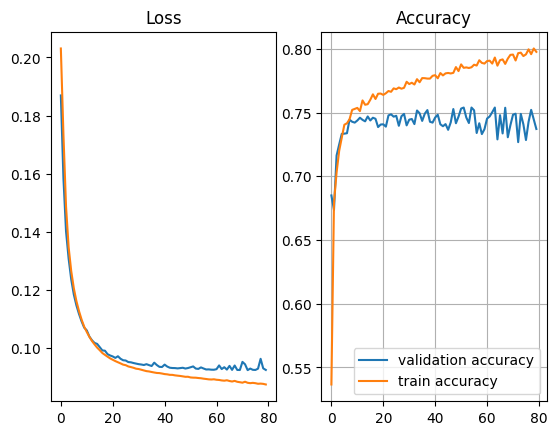

In [76]:
_, ax = plt.subplots(ncols=2, nrows=1)

ax[0].plot(np.arange(len(val_losses)), val_losses, label='validation loss')
ax[0].plot(np.arange(len(train_losses)), train_losses, label='train loss')
ax[0].set_title('Loss')

ax[1].plot(np.arange(len(val_accuracies)), val_accuracies, label='validation accuracy')
ax[1].plot(np.arange(len(train_accuracies)), train_accuracies, label='train accuracy')
ax[1].set_title('Accuracy')

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def plot_confusion_matrix_4class(predictions, actual_labels, class_names=None):
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(4)]
    
    cm = confusion_matrix(actual_labels, predictions)
    accuracy = accuracy_score(actual_labels, predictions) * 100

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                     xticklabels=class_names,
                     yticklabels=class_names)
    
    ax.set_xlabel(f'Predicted Labels (Accuracy: {accuracy:.2f}%)')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix for 4-class Classification')
    plt.tight_layout()
    plt.show()


100%|██████████| 60/60 [00:06<00:00,  8.83it/s]


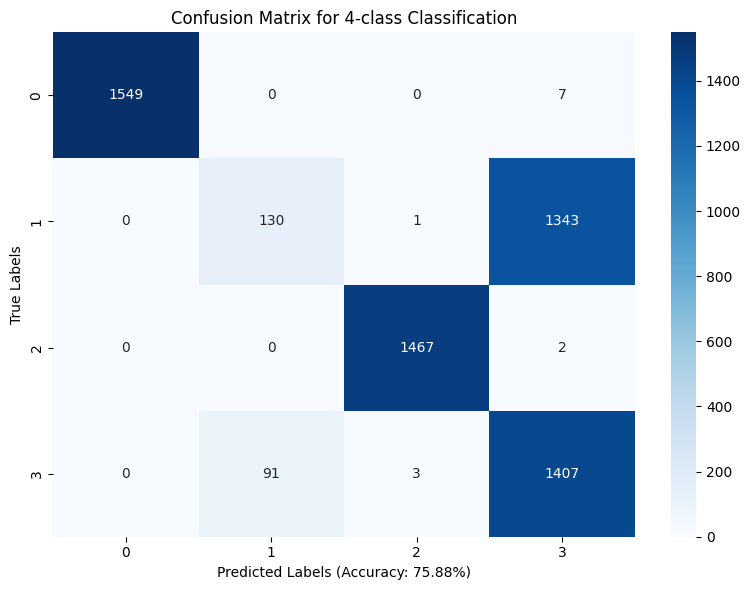

In [ ]:
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4
)

def test_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in tqdm(dataloader):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch_labels.cpu().tolist())

    return all_preds, all_labels

class_names = ['0', '1', '2', '3']  # replace with your actual class names

test_predictions, test_labels = test_model(model, test_dataloader, device)
plot_confusion_matrix_4class(test_predictions, test_labels, class_names)